### Some terms you need to understand for understanding Large Language Models
  - logits
  - softmax
  - cross entropy
  - one hot encoding
  - encoding/embedding
  - tokens, tokenizer
  - attention
    - multi-head attention
  - **positional encoding**
    - rotary positional encoding (Used in LLama)
  - *transformer*
    - *encoder*
    - *decoder*
    - Residual Connection
    - *Feed Forward Layer*
    - *Layer Normalization*
      - LLama suggests RMSNorm instead <https://arxiv.org/abs/1910.07467>
  - optimizer
  - Important players in the AI Ecosystem
  - How to train/fine tune!

### What is positional encoding?
  - Intuitively, we perturb the embeddings of tokens to encode *spatial positions/relationships* of the tokens to the embedding.
    - The NN *learns* the spatial relationship between the tokens
  - Experimentally, it seems to produce faster training (i.e. it converges faster)
    - Unclear if more training without PE can approach similar loss values.
  - How does it work?
    - Magic! (err!! **Divine Providence**)

### Rotary Position Encoding <https://arxiv.org/abs/2104.09864> (for LLama)
  - >Transformer-based language modeling usually leverages the position information of individual tokens through a self-
attention mechanism. ... $q_{m}^{T}  k_n$ typically enables knowledge conveyance between
tokens at different positions. In order to incorporate relative position information, we require the inner product of query
$q_m$ and key $k_n$ to be formulated by a function $g$, which takes only the word embeddings $x_m$ , $x_n$, and their relative
position $m − n$ as input variables. In other words, we hope that the inner product encodes position information only in
the relative form:
  - Intuitively, it is treating consecutive values in the embedding for a token as a point in 2-space and rotating it. The angle of rotation is proportional to $m - n$ the difference between the positions of the tokens
  - Find a solution such that $\displaystyle⟨f_q (x_m , m), f_k (x_n , n)⟩ = g(x_m , x_n, m − n)$
    - i.e only depends on $x_m$ and $x_n$ and $m-n$
    - $\begin{aligned} f_q(x_m, m) &= (W_q @ x_m) \displaystyle e^{i m \theta}\\
       f_k(x_n, n) &= (W_k @ x_n) \displaystyle e^{i n \theta}\\
       g(x_m, x_n, m − n) &=  Re[(W_q x_m ) @ (W_k x_n)^{∗} \displaystyle e^{i(m−n)\theta}]\\
       \end{aligned}$

    - $(W_k @ x_n)^{∗}$ is complex conjugate of $(W_k @ x_n)$
      - $conj(x + iy) = x - iy$
      
  - R can be of this form
    - $f_{(q,k)}(x_m, m) = \begin{pmatrix}
                               cos(m \theta) & -sin (m \theta)\\
                               sin(m \theta) & cos (m \theta)\\
                             \end{pmatrix} 
                             \begin{pmatrix}
                               \displaystyle W^{11}_{(q,k)} & W^{12}_{(q,k)}\\
                               \displaystyle W^{21}_{(q,k)} & W^{22}_{(q,k)}\\
                             \end{pmatrix}
                             \begin{pmatrix}
                               x^{(1)}_m\\
                               x^{(2)}_m\\
                             \end{pmatrix}
                             $ (Eqn 13 in <https://arxiv.org/abs/2104.09864>)

In [ ]:
import torch
from torch.nn import functional as F
from torch import nn
from tinytorch.MyStuff import *
from tinytorch.tensorhelpers import *
import math
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.patches import Ellipse
from matplotlib.text import OffsetFrom
from subroutines import *

In [ ]:
def rot2d(theta, device='cpu'):
  return torch.tensor([[math.cos(theta), -math.sin(theta)],
                       [math.sin(theta), math.cos(theta)]], dtype=float, device=device)

PI = math.pi
PI2 = 2*PI
def toRAD(degree):
  return PI * degree/180.0

In [ ]:
pt = torch.tensor([1.0, 0], dtype=float)
m2 = toRAD(15)
m3 = rot2d(m2)
print(hprt(m3))
Rtn = [pt]

In [ ]:
xs = [ t.tolist()[0] for t in Rtn ]
ys = [ t.tolist()[1] for t in Rtn ]
fig, ax = plt.subplots()
plt.axis([-1.4, 1.4, -1.4, 1.4])
ax.scatter(xs, ys, marker='s', label=f'[1,0] rotated {(len(Rtn)-1)*15.0} degrees')
ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')
#fig.set_size_inches(4, 4)
plt.axis('equal')
plt.legend(loc='upper right')
plt.show()
Rtn.append(m3 @ Rtn[-1])  

In [ ]:
print(hprt(rot2d(toRAD(0))))

### Rotation matrix, continued
  - >To generalize our results in 2D to any $x_i \in R^d$ where $d$ is even,
    >we divide the d-dimension space into d/2 sub-spaces and combine them in the merit of the linearity of the inner product, turning $f_{q,k}$ into:
  - $\displaystyle f_{(q, k)}(x_m, m) = \displaystyle R^{d}_{\theta,m} W_{(q,k)} x_m$ (eqn 14)
  - This the required matrix $R$
    $\begin{pmatrix}
      cos(m\theta_1) & -sin(m\theta_1) & 0 & 0 & ... & 0 & 0\\
      sin(m\theta_1) & con(m\theta_1) & 0 & 0 & ... & 0 & 0\\
       0 & 0 & cos(m\theta_2) & -sin(m\theta_2) & ... & 0 & 0\\
       0 & 0 & sin(m\theta_2) & cos(m\theta_2) & ... & 0 & 0\\
       ... & ... & ... & ... & ... & 0 & 0\\
       0 & 0 & 0 & 0 & ... & cos(m\theta_{d]2}) & -sin(m\theta_{d/2}) \\
       0 & 0 & 0 & 0 & ... & sin(m\theta_{d]2}) & cos(m\theta_{d/2}) \\      
    \end{pmatrix}$

  - Therefore, the attention formula then becomes $q^T_m k_n = (R^d_{\theta,m} W_q x_m)^T (R^d_{\theta,n} W_k x_n) = x^T W_qR^d_{\theta,n-m} W_k x_n$ (eqn 16)
    - where $\theta_i = 10000^{-2(i-1)/d}, i \in [1, 2, ..., d/2]$
    - $d$ is `nEmbed`
    - $m$ and $n$ are the absolute positions of $x_m$ and $x_n$, respectively
    - $R^d_{\theta,m-n} = (R^d_{\theta,m})^T @ R^d_{\theta,n}$
  - The above matrix is mostly zeros, so we can derive a much more efficient operation to generate the desired rotation.
  - 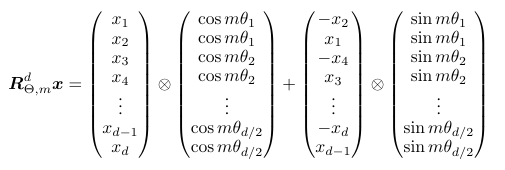
  - 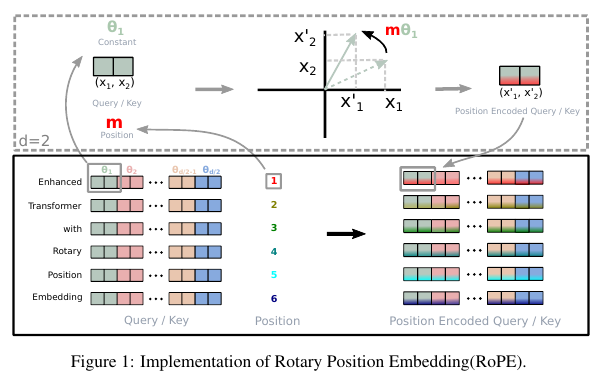
    - RPE is applied AFTER q and k have been multipled by the W matrix

### So what happens if we do a dot product of TWO rotated points??

In [ ]:
pt = torch.tensor([1.0, 0], dtype=float)
m2 = toRAD(15)
m3 = rot2d(m2)
print(hprt(m3))
Rtn = [ pt ]
Count = -2
Faster = 0

In [ ]:
def setupDeg():
  global Rtn, xs, ys, deg, outer, outerIdx, xso, yso, Faster
  xs = [ t.tolist()[0] for t in Rtn ]
  ys = [ t.tolist()[1] for t in Rtn ]
  deg = 15.0 * (len(Rtn)-1)
  outer = [ a*b for i,a in enumerate(Rtn) for j,b in enumerate(Rtn[:i+1]) ]
  outerIdx = [ (i,j) for i,a in enumerate(Rtn) for j, b in enumerate(Rtn[:i+1]) ] 
  xso = [ t.tolist()[0] for t in outer ]
  yso = [ t.tolist()[1] for t in outer ]
  print(f'setup {len(Rtn)=} points, {len(outer)=} dot products')
def drawDeg():
  global fig, ax, currDot, currPoints, cxs, cys, Count, Faster
  global Rtn, xs, ys, deg, outer, outerIdx, xso, yso
  currDot = 'None'
  fig, ax = plt.subplots()
  plt.axis([-1.5, 1.5, -1.5, 1.5])
  ax.scatter(xs, ys, c='b', marker='s', label=f'[1.0,0] rotated {deg:.2f} degrees')
  if Count == -2:
    plt.title( vprt(f'Showing [1.0,0] rotated to {deg} degrees. {len(Rtn)} points shown'))
    Count += 1
  elif Count == -1:
    plt.title(vprt(f'Showing [1.0,0] rotated to {deg}. {len(Rtn)} points shown', f'About to show {len(outerIdx)} dot products'))
    Count += 1
  elif Count < len(outer):
    currDot = outerIdx[Count]
    currPoints = Rtn[currDot[0]],Rtn[currDot[1]]
    cxs = [ t.tolist()[0] for t in currPoints]
    cys = [ t.tolist()[1] for t in currPoints]
    ax.scatter(xso[0:Count], yso[0:Count], c='r', marker='o', label='prior dot product')
    ax.scatter(xso[Count:Count+1], yso[Count:Count+1], c='g', marker='o', label='current dot product')
    ax.scatter(cxs, cys, c='y', marker='s', label=f'current points in dot product')
    plt.title(vprt(f'Showing [1.0,0] rotated to {deg} degrees. {len(Rtn)} points shown', 
                   f'showing {Count+1}/{len(outer)} dot product', 
                   hprt(a=currPoints[0],b=currPoints[1])))
    Count += 1
    if Faster:
      Count = len(outer)
  elif Count == len(outer):
    # reached end
    plt.title(vprt(f'Showing [1.0,0] rotated to {deg} degrees', f'showed all {len(outerIdx)} dot products', 
                  f'About to show [1,0] rotated to {deg+15} degree'))
    ax.scatter(xso[:Count+1], yso[:Count+1], c='r', marker='o', label='dot product')
    Rtn.append(m3 @ Rtn[-1])
    Count = -2
  ax.axhline(y=0, color='k')
  ax.axvline(x=0, color='k')
  if len(Rtn) <= 3 and not Faster:
    plt.legend()
  #fig.set_size_inches(4, 4)
  plt.axis('equal')
  plt.show()
  print(f'{len(Rtn)-1=} {len(outer)=} {Count=} {currDot=}')

In [ ]:
# run this cell repeatedly!
Faster = 1
setupDeg()
drawDeg()

### The Hypothesis behind using 2D rotations is:
 - dot product of 2d rotations preserves some information about where where the original points were
 - Similarly, subtractions/additions of 2d points preserve some information about the original two points.
 - Therefore, by perturbing the encoding of the tokens with their relative positions, we hypothesize that the LLM model learns to pick up clues about the spatial positions of the tokens and how they might influence the "next token" decision.
### We really don't know **WHY** Positional Encoding works.
### We also don't know why Rotary PE is better than normal PE.
### We also don't understand why we need to perturb different points of the token embedding differently than other parts of the embedding, for the **same** token

### How is it actually coded up in LLMs?

In [ ]:
# https://pytorch.org/docs/stable/generated/torch.outer.html
v1 = torch.arange(1., 5.)
v2 = torch.arange(1., 4.)
v3 = torch.outer(v1, v2)
v3a = v1.unsqueeze(1) @ v2.unsqueeze(0)
# v1 (n) -> (n,1), v2 (m) -> (1,m) --> (n,m)
print(hprt(Shapes(v1=v1, v2=v2, v3=v3, v3a=v3a)))

In [ ]:
# https://pytorch.org/docs/stable/generated/torch.polar.html
import numpy as np
abs = torch.tensor([1, 1, 1, 1], dtype=torch.float64)
# note: pi/4 == 45 degrees!
angle = torch.tensor([np.pi / 2, np.pi / 4, 5*(np.pi / 4), np.pi/6], dtype=torch.float64)
z = torch.polar(abs, angle)
print(printTensors(abs=abs, angle=angle, z=z))

In [ ]:
# https://pytorch.org/docs/stable/generated/torch.ones_like.html
# https://pytorch.org/docs/stable/generated/torch.empty.html#torch-empty
input = torch.empty(2, 3)
output = torch.ones_like(input)
print(Shapes(input=input, output=output))

In [ ]:
# https://pytorch.org/docs/stable/generated/torch.view_as_complex.html
# https://pytorch.org/docs/stable/generated/torch.view_as_real.html
K = torch.arange(16).view(2,2,2,-1).float()
C = torch.view_as_complex(K)
D = torch.view_as_real(C)
print(vprt(Shapes(K=K, C=C, D=D)))

### The following code is adopted from working Llama3
  - `precompute_theta_pos_frequencies()` is called before the LLM actually examines any tokens
  - `apply_rotary_embedding()` is called from the Attention Layer,
  - input tensor `x` is of shape $(B, seqLen, nEmbed)$

In [ ]:
def precompute_theta_pos_frequencies(head_dim: int, seq_len: int, theta: float = 10000.0):
  # As written in the paragraph 3.2.2 of the paper
  # >> In order to generalize our results in 2D to any xi ∈ Rd where **d is even**, [...]
  assert head_dim % 2 == 0, "Dimension must be divisible by 2"
  # Build the theta parameter
  # According to the formula theta_i = 10000^(-2(i-1)/dim) for i = [1, 2, ... dim/2]
  # Shape: (Head_Dim / 2)
  theta_numerator = torch.arange(0, head_dim, 2).float()
  # Shape: (Head_Dim / 2)
  theta = 1.0 / (theta ** (theta_numerator / head_dim)) # (Dim / 2)
  # Construct the positions (the "m" parameter)
  # Shape: (Seq_Len)
  m = torch.arange(seq_len)
  # Multiply each theta by each position using the outer product.
  # Shape: (Seq_Len) outer_product* (Head_Dim / 2) -> (Seq_Len, Head_Dim / 2)
  freqs = torch.outer(m, theta).float()
  # We can compute complex numbers in the polar form c = R * exp(m * theta), where R = 1 as follows:
  # (Seq_Len, Head_Dim / 2) -> (Seq_Len, Head_Dim / 2)
  freqs_complex = torch.polar(torch.ones_like(freqs), freqs)
  return freqs_complex, freqs, m, theta, theta_numerator

def apply_rotary_embeddings(x: torch.Tensor, freqs_complex: torch.Tensor):
  # Separate the last dimension pairs of two values, representing the real and imaginary parts of the complex number
  # Two consecutive values will become a single complex number
  # (B, Seq_Len, H, Head_Dim) -> (B, Seq_Len, H, Head_Dim/2)
  x_complex = torch.view_as_complex(x.float().reshape(*x.shape[:-1], -1, 2))
  # Reshape the freqs_complex tensor to match the shape of the x_complex tensor. 
  # So we need to add the batch dimension and the head dimension
  # (Seq_Len, Head_Dim/2) --> (1, Seq_Len, 1, Head_Dim/2)
  freqs_complex = freqs_complex.unsqueeze(0).unsqueeze(2)
  # Multiply each complex number in the x_complex tensor by the corresponding complex number in the freqs_complex tensor
  # Which results in the rotation of the complex number as shown in the Figure 1 of the paper
  # (B, Seq_Len, H, Head_Dim/2) * (1, Seq_Len, 1, Head_Dim/2) = (B, Seq_Len, H, Head_Dim/2)
  print(f'{list(x_complex.shape)} @ {freqs_complex.shape}')
  x_rotated = x_complex * freqs_complex
  # Convert the complex number back to the real number
  # (B, Seq_Len, H, Head_Dim/2) -> (B, Seq_Len, H, Head_Dim/2, 2)
  x_out = torch.view_as_real(x_rotated)
  # (B, Seq_Len, H, Head_Dim/2, 2) -> (B, Seq_Len, H, Head_Dim)
  x_out = x_out.reshape(*x.shape)
  return x_out.type_as(x)

In [ ]:
nEmbed = 8
seqLen = 6
nHeads = 1
nBatch = 1
headDim = nEmbed // nHeads 

In [ ]:
PreComputed = precompute_theta_pos_frequencies(headDim, seqLen)
freqs_complex, freqs, m, theta, theta_numerator = PreComputed

In [ ]:
print(vprt(Shapes(theta_numerator=theta_numerator), Shapes(theta=theta), Shapes(m=m), Shapes(freqs=freqs), Shapes(freqsC=freqs_complex)))

In [ ]:
print(printTensorsAll(theta_numerator=theta_numerator))

# x0 is a fake embedding vector for some token, with special values to see what effect RPE has

In [ ]:
x00 = torch.tensor([1, 0], dtype=torch.float)
x0 = torch.cat([x00, x00, x00, x00])

In [ ]:
print(printTensors(x0=x0))

In [ ]:
# (B, seqLen, H, headDim)
# or (1, 6, 1, 8)
x = torch.stack([x0]*seqLen).unsqueeze(0).unsqueeze(2)
print(printTensors(x=x))

### The above stack and unsqueeze is needed because the above  apply_rotary_embeddings() is found in the attention layer.
  - need to take into account $(B, seqLen, H, HeadDim)$

In [ ]:
x.shape

In [ ]:
x1 = x.float().reshape(*x.shape[:-1], -1, 2)
x_complex = torch.view_as_complex(x1)

In [ ]:
print(printTensors(x0=x0.view(-1,2), x=x, x1=x1, x_complex=x_complex))

In [ ]:
f2 = freqs_complex.unsqueeze(0).unsqueeze(2)
print(vprt(printTensors(freqs_complex=freqs_complex), printTensors(f2=f2)))

In [ ]:
y = apply_rotary_embeddings(x, freqs_complex)

In [ ]:
print(hprt(y=y.squeeze(), x=x.squeeze()))

In [ ]:
y1 = y.squeeze()

In [ ]:
PT = 0
r = 0
def drawRPE(y, x0):
  global fig, ax, PT, r
  seqLen,nEmbed = y.shape
  assert nEmbed == x0.shape[0]   
  assert nEmbed % 2 == 0
  nPoints = nEmbed // 2
  if r >= seqLen:
    r = 0
    PT = 0
    return
  # for each seqLen
  orig = x0.view(-1,2)
  repl = y[r].view(-1,2)
  fig, ax = plt.subplots()
  plt.axis([-1.5, 1.5, -1.5, 1.5])
  ax.axhline(y=0, color='k')
  ax.axvline(x=0, color='k')
  if PT < nPoints:
    origPT = orig[PT]
    replPT = repl[PT]
    oxs = orig[:, 0]
    oys = orig[:, 1]
    rxs = repl[:, 0]
    rys = repl[:, 1]
    assert origPT[0] == oxs[PT] and origPT[1] == oys[PT]
    plt.title(hprt(f'row {r}, point {PT}', ORIG=origPT, REPL=replPT))
    ax.scatter(oxs[PT], oys[PT], c='r', marker='o', label='original')
    ax.scatter(rxs[PT], rys[PT], c='g', marker='s', label='rotated')
    PT += 1
  else:
    plt.title(f'showed row {r}. abouto to show row {r+1}')
    r += 1
    PT = 0

In [ ]:
drawRPE(y1, x0)

In [ ]:
nPoints = 360 // 15
nEmbed = 2 * nPoints
seqLen = 8

In [ ]:
nHeads = 1
nBatch = 1
headDim = nEmbed // nHeads 
# using only one head!

In [ ]:
original = torch.tensor([1,0]).double()

In [ ]:
original.shape

In [ ]:
# x0 = torch.stack([ rot2d(toRAD(15*k)) @ original for k in range(nPoints) ]).float()

In [ ]:
x0 = torch.stack( [original for k in range(nPoints) ]).float()

In [ ]:
x0.shape

In [ ]:
x1 = torch.stack([x0.view(-1)]*seqLen).unsqueeze(0).unsqueeze(2)
x1.shape

In [ ]:
x2 = x1.unsqueeze(0).unsqueeze(2)

In [ ]:
x2.shape

In [ ]:
PreComputed = precompute_theta_pos_frequencies(headDim, seqLen)
freqs_complex, freqs, m, theta, theta_numerator = PreComputed

In [ ]:
y = apply_rotary_embeddings(x2, freqs_complex)

In [ ]:
y1 = y.squeeze()

In [ ]:
PT = 0
r = 0

In [ ]:
x0.shape

In [ ]:
drawRPE(y1, x0.view(-1))